In [2]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
import FiniteDiff
import ForwardDiff as FD
import Convex as cvx 
import ECOS
using LinearAlgebra
using Plots
using Random
using JLD2
using Test
using MeshCat
const mc = MeshCat
using TrajOptPlots
using StaticArrays
using Printf

  Activating project at `~/CMU/Study/18660 Optimization/project/OptimizationFinalProj`


In [3]:
include(joinpath(@__DIR__, "utils","ilc_visualizer.jl"))

vis_traj! (generic function with 1 method)

We will model the dynamics of the car as with a simple nonlinear bicycle model, with the following state and control:

$$\begin{align} x = \begin{bmatrix} p_x \\ p_y \\ \theta \\ \delta \\ v \\ \omega \end{bmatrix}, &\quad \quad u = \begin{bmatrix} a \\ \dot{\delta} \end{bmatrix}  \end{align} $$ 

where $p_x$ and $p_y$ describe the 2d position of the bike, $\theta$ is the orientation, $\delta$ is the steering angle, and $v$ is the velocity. The controls for the bike are acceleration $a$, and steering angle rate $\dot{\delta}$.  

In [4]:
function estimated_car_dynamics(model::NamedTuple, x::Vector, u::Vector)::Vector
    # nonlinear bicycle model continuous time dynamics 
    px, py, θ, δ, v = x 
    a, δdot = u 
    
    β = atan(model.lr * δ, model.L)
    s,c = sincos(θ + β)
    ω = v*cos(β)*tan(δ) / model.L
    
    vx = v*c 
    vy = v*s 
    
    xdot = [
        vx,
        vy,
        ω,
        δdot, 
        a
    ]
    
    return xdot 
end
function rk4(model::NamedTuple, ode::Function, x::Vector, u::Vector, dt::Real)::Vector
    k1 = dt * ode(model, x,        u)
    k2 = dt * ode(model, x + k1/2, u)
    k3 = dt * ode(model, x + k2/2, u)
    k4 = dt * ode(model, x + k3,   u)
    return x + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
end   

rk4 (generic function with 1 method)

We have computed an optimal trajectory $X_{ref}$ and $U_{ref}$ for a moose test trajectory offline using this `estimated_car_dynamics` function. Unfortunately, this is a highly approximate dynamics model, and when we run $U_{ref}$ on the car, we get a very different trajectory than we expect. This is caused by a significant sim to real gap. Here we will show what happens when we run these controls on the true dynamics:

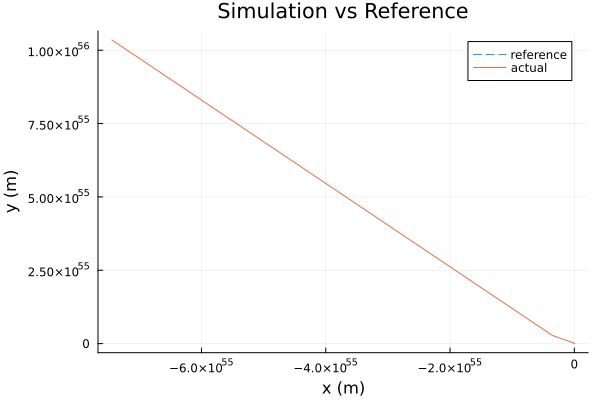

Test Summary:   | Time
sim to real gap | None  28.2s


Test.DefaultTestSet("sim to real gap", Any[], 0, false, false, true, 1.682271782567569e9, 1.682271810722283e9)

In [5]:
function load_car_trajectory()
    # load in trajectory we computed offline 
    path = joinpath(@__DIR__, "utils","init_control_car_ilc.jld2")
    F = jldopen(path)
    Xref = F["X"]
    Uref = F["U"]
    close(F)
    return Xref, Uref
end
function true_car_dynamics(model::NamedTuple, x::Vector, u::Vector)::Vector
    # true car dynamics 
    px, py, θ, δ, v = x 
    a, δdot = u 
    
    # sluggish controls (not in the approximate version)
    a = 0.9*a - 0.1 
    δdot = 0.9*δdot - .1*δ + .1
    
    β = atan(model.lr * δ, model.L)
    s,c = sincos(θ + β)
    ω = v*cos(β)*tan(δ) / model.L
    
    vx = v*c 
    vy = v*s 
    
    xdot = [
        vx,
        vy,
        ω,
        δdot, 
        a
    ]
    
    return xdot 
end

@testset "sim to real gap" begin 
    # problem size 
    nx = 5
    nu = 2
    dt = 0.1
    tf = 5.0 
    t_vec = 0:dt:tf 
    N = length(t_vec)
    model = (L = 2.8, lr = 1.6)
    
    # optimal trajectory computed offline with approximate model 
    Xref, Uref = load_car_trajectory()
    
    # simulated Uref with the true car dynamics and store the states in Xsim
    Xsim = [zeros(nx) for i = 1:N]
    Xsim[1] = Xref[1]
    P = ones(2,5) * -100.8
    D = ones(2,5) * 0.2
    Xlast = Xref[1]
    for i = 1:N-1
        u_next = Uref[i] - P * (Xref[i] - Xsim[i]) - D * (Xsim[i] - Xlast)
        Xsim[i+1] = rk4(model, true_car_dynamics, Xsim[i], u_next, dt)
        Xlast = Xsim[i]
    end

    
    # --------plotting/animation-------
    Xm= hcat(Xsim...)
    Xrefm = hcat(Xref...)
    plot(Xrefm[1,:], Xrefm[2,:], ls = :dash, label = "reference",
         xlabel = "x (m)", ylabel = "y (m)", title = "Simulation vs Reference")
    display(plot!(Xm[1,:], Xm[2,:], label = "actual"))
    
end

### Optimal PID

To encourage the trajectory of the bike to follow the reference, the objective value for this problem is the following:
$$  J(X) = \sum_{i=1}^{N-1} \bigg[ \frac{1}{2} (x_i - x_{ref,i})^TQ(x_i - x_{ref,i})]$$

We are to linearize our approximate dynamics model about $X_{ref}$ and $U_{ref}$ to get the following Jacobians:

$$ A_k = \frac{\partial f}{\partial x}\bigg|_{x_{ref,k},u_{ref,k}}, \quad \quad B_k = \frac{\partial f}{\partial u}\bigg|_{x_{ref,k},u_{ref,k}} $$

where $f(x,u)$ is our **approximate discrete** dynamics model (`estimated_car_dynamics` + `rk4`). **You will form these Jacobians exactly once, using `Xref` and `Uref`.**  Here is a summary of the notation:

- $X_{ref}$ (`Xref`) -  Optimal trajectory computed offline with approximate dynamics model. 
- $U_{ref}$ (`Uref`) -  Optimal controls computed offline with approximate dynamics model. 
- $X_{sim}$ (`Xsim`) -  Simulated trajectory with real dynamics model.


In the second step of ILC, we solve the following optimization problem:

   $$ \begin{align} \min_{\Delta x_{1:N}} \quad & J(X_{sim} + \Delta X)\\ 
 \text{st} \quad & \Delta x_1 = 0 \\ 
 & \Delta x_{k+1} = A_k \Delta x_k - P (X_{sim_k} - X_{ref_k}) - D (X_{sim_k} - X_{sim_{k-1}}) \text{ for } k = 2,3,\ldots,N-1  \\
 \end{align}$$
 

In [6]:
function trajectory_cost(Xsim::Vector{Vector{Float64}}, # simulated states 
    Ubar::Vector{Vector{Float64}}, # simulated controls (ILC iterates this)
    Xref::Vector{Vector{Float64}}, # reference X's we want to track
    Uref::Vector{Vector{Float64}}, # reference U's we want to track 
    Q::Matrix,                     # LQR tracking cost term 
    R::Matrix,                     # LQR tracking cost term
    Qf::Matrix,                    # LQR tracking cost term
    cost_type::String              # "Q" or "pos_RMSE" or "orient_RMSE"
)::Float64                     # return cost J 

    # Initialize the costs
    J = 0
    N = length(Xsim)

    # Set up the cost matrix based on the cost type
    if cost_type == "Q"
        cost_mat = Q
    elseif cost_type == "pos_RMSE"
        # only position
        cost_mat = diagm([1,1,0,0,0])
    elseif cost_type == "orient_RMSE"
        # only orientation
        cost_mat = diagm([0,0,1,0,0])
    else
        error("cost_type must be QR or L2")
    end

    # Actually calculate the cost
    for i = 1:N-1
        xdiff = Xsim[i] - Xref[i]
        J += (Xsim[i] - Xref[i])' * cost_mat * (Xsim[i] - Xref[i])
    end

    # For root mean square errors, divide by N and take sqrt
    if endswith(cost_type, "RMSE")
        J = sqrt(J / N)
    end

    return J
end

function vec_from_mat(Xm::Matrix)::Vector{Vector{Float64}}
    # convert a matrix into a vector of vectors 
    X = [Xm[:, i] for i = 1:size(Xm, 2)]
    return X
end

# Optimization loop for determining P,D gains 
function optim_pd(Xsim::Vector{Vector{Float64}}, # simulated states 
    Ubar::Vector{Vector{Float64}}, # simulated controls (ILC iterates this)
    Xref::Vector{Vector{Float64}}, # reference X's we want to track
    Uref::Vector{Vector{Float64}}, # reference U's we want to track 
    As::Vector{Matrix{Float64}},   # vector of A jacobians at each time step 
    Bs::Vector{Matrix{Float64}},   # vector of B jacobians at each time step 
    Q::Matrix,                     # LQR tracking cost term 
    R::Matrix,                     # LQR tracking cost term
    Qf::Matrix                     # LQR tracking cost term
) 
    # Solve optimization problem for ILC update
    N = length(Xsim)
    nx, nu = size(Bs[1])

    # Create variables 
    ΔX = cvx.Variable(nx, N)
    ΔU = cvx.Variable(nu, N - 1)
    P = cvx.Variable(2, 5)
    D = cvx.Variable(2, 5)

    # TODO: Make lambda an optimizable variable also
    lambda = 0.4
    # lambda = cvx.Variable(1)

    # Cost function (tracking cost on Xref, Uref)
    # TODO: Try including I into the formulation
    cost = 0
    for i = 1:N-1
        xdiff = (Xsim[i] - Xref[i]) + ΔX[:, i]
        udiff = (Ubar[i] - Uref[i]) + ΔU[:, i]

        state_cost = cvx.quadform(xdiff, Q)
         
        # TODO: Test with and without control cost
        control_cost = 0 # cvx.quadform(udiff, R)

        # NOTE: Regularization needed because P,D being too big is bad for PD control
        # NOTE: L1 Regularization will tend to result in sparser P,D matrices
        # TODO: Try L2 Regularization?
        L_norm = 1
        norm_cost = lambda * (cvx.LinearAlgebra.norm(vec(P), L_norm) + cvx.LinearAlgebra.norm(vec(D), L_norm))

        cost += state_cost + control_cost + norm_cost
    end

    # Problem instance 
    prob = cvx.minimize(cost)

    # Initial condition constraint
    prob.constraints += ΔX[:, 1] == 0

    # Dynamics constraints
    xlast = Xsim[1]
    for i = 1:N-1
        deltaU = -P * (Xref[i] - Xsim[i]) - D * (Xsim[i] - xlast)
        
        ΔU[:, i] == deltaU
        control_affine_constraint = ΔX[:, i+1] == As[i] * ΔX[:, i] + Bs[i] * deltaU

        prob.constraints += control_affine_constraint
        
        xlast = Xsim[i]
    end

    # Lambda constraint
    # prob.constraints += lambda >= 0
    # prob.constraints += lambda < 1

    # run and solve
    cvx.solve!(prob, ECOS.Optimizer; silent_solver=true)

    P = P.value
    D = D.value
    println("P = ", P)
    println("D = ", D)

    return P, D
end

optim_pd (generic function with 1 method)

Here we will run the optimization for determining the P,D gain matrices given ideal and approximate dynamics. 

The resulting plots should show the simulated trajectory `Xsim` tracks `Xref` very closely, but there should be a significant difference between `Uref` and `Ubar`.

Pre Calculating Jacobians... 
iter     objv        |ΔU|     


------------------------------
P = 

[-0.8673125294084775 2.0945132010533978e-9 1.5570311164129347e-10 1.1632863215491815e-10 -1.8673456878373544e-10; -0.1721174646333425 -0.05343535554897715 5.2815049448602273e-11 6.484943227165213e-11 -4.4948858335167675e-11]
D = [-0.5310637438642244 -2.6457498149529553e-10 -1.1552326426778499e-11 2.0839014997990093e-12 -8.202167448154588e-12; 0.19686300073064436 -5.322635627962794e-11 5.3333788946801554e-11 6.170246201124922e-11 2.5439864648778315e-11]


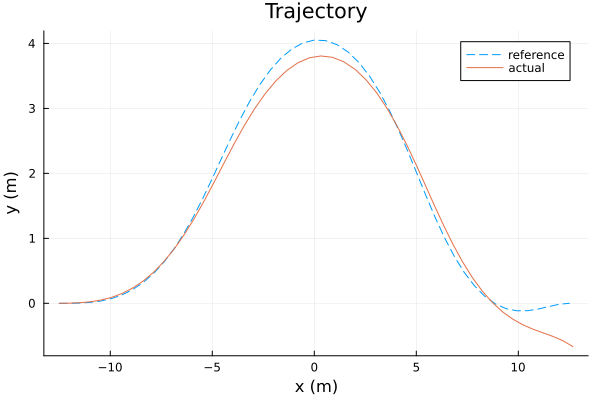

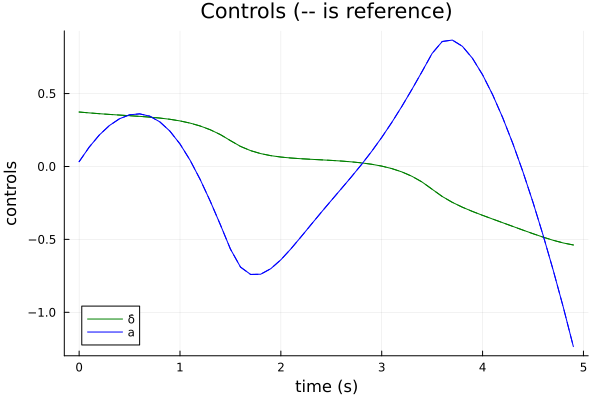

Q Trajectory Cost:  2.555e+03
RMSE Position Trajectory Cost:  7.071e+00
RMSE Orientation Trajectory Cost:  9.332e-01


┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat /home/sam/.julia/packages/MeshCat/GlCMx/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("traj" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("s23" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x73, 0x32, 0x33], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s14" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x73, 0x31, 0x34], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s18" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x73, 0x31, 0x38], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s44" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x73, 0x34, 0x34], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "p43" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x70, 0x34, 0x33], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s19" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x73, 0x31, 0x39], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s6" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x61, 0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x73, 0x36], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s11" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x73, 0x31, 0x31], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s15" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x73, 0x31, 0x35], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "p28" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x70, 0x32, 0x38], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}())…)), "robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("chassis" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6f, 0x6d, 0x2f, 0x63, 0x68, 0x61, 0x73, 0x73, 0x69, 0x73], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTre

Test Summary:                          |   Time
Optimization for PD Gain Determination | None  1m20.8s


Test.DefaultTestSet("Optimization for PD Gain Determination", Any[], 0, false, false, true, 1.682271812361496e9, 1.682271893186828e9)

In [7]:
@testset "Optimization for PD Gain Determination" begin

    # problem size 
    nx = 5
    nu = 2
    dt = 0.1
    tf = 5.0
    t_vec = 0:dt:tf
    N = length(t_vec)

    # optimal trajectory computed offline with approximate model 
    Xref, Uref = load_car_trajectory()

    # initial and terminal conditions 
    xic = Xref[1]
    xg = Xref[N]

    # LQR tracking cost to be used in ILC 
    Q = diagm([1, 1, 0.1, 0.1, 0.1])
    R = 0.1 * diagm(ones(nu))
    Qf = 1 * diagm(ones(nx))

    # load all useful things into params 
    model = (L=2.8, lr=1.6)

    params = (Q=Q, R=R, Qf=Qf, xic=xic, xg=xg, Xref=Xref, Uref=Uref,
        dt=dt,
        N=N,
        model=model)


    # this holds the sim trajectory (with real dynamics)
    Xsim = [zeros(nx) for i = 1:N]

    # this is the feedforward control ILC is updating 
    Ubar = [zeros(nu) for i = 1:(N-1)]
    Ubar .= Uref # initialize Ubar with Uref 

    # calculate Jacobians 
    As = [zeros(nx, nx) for i = 1:N-1]
    Bs = [zeros(nu, nu) for i = 1:N-1]

    @printf("Pre Calculating Jacobians... \n")
    for i = 1:N-1
        As[i] = FD.jacobian(dx -> rk4(model, estimated_car_dynamics, dx, Uref[i], dt), Xref[i])
        Bs[i] = FD.jacobian(du -> rk4(model, estimated_car_dynamics, Xref[i], du, dt), Uref[i])
    end

    # Initialize P, D to 0
    # TODO: test different initializations?
    # NOTE: Different initializations should not affect the solution because convex
    P = zeros(2, 5)
    D = zeros(2, 5)
    
    # logging stuff 
    @printf "iter     objv        |ΔU|     \n"
    @printf "------------------------------\n"
    
    # Move the robot (forward rollout)
    Xsim[1] = xic
    Xlast = xic
    for i = 1:N-1
        u_next = Uref[i] - P * (Xref[i] - Xsim[i]) - D * (Xsim[i] - Xlast)
        Xsim[i+1] = rk4(model, true_car_dynamics, Xsim[i], u_next, dt)
        Xlast = Xsim[i]
    end
    
    # Solve optimization problem for update (optim_pd)
    P, D = optim_pd(Xsim, Ubar, Xref, Uref, As, Bs, Q, R, Qf)

    # Metrics
    metrics = Dict{String, Float32}()

    # Trajectory_cost
    # Use proper RMSE absolute trajectory error
    # Also include Q-trajectory cost (controls objective cost)
    # TODO: See section IV of https://rpg.ifi.uzh.ch/docs/IROS18_Zhang.pdf
    metrics["Q_traj_cost"] = trajectory_cost(Xsim, Ubar, Xref, Uref, Q, R, Qf, "Q")
    metrics["RMSE_pos_traj_cost"] = trajectory_cost(Xsim, Ubar, Xref, Uref, Q, R, Qf, "pos_RMSE")
    metrics["RMSE_orient_traj_cost"] = trajectory_cost(Xsim, Ubar, Xref, Uref, Q, R, Qf, "orient_RMSE")

    # Difference from final pose

    # Logging
    # @printf("Trajectory Cost: %10.3e\n", traj_cost)
    @printf("Q Trajectory Cost: %10.3e\n", metrics["Q_traj_cost"])
    @printf("RMSE Position Trajectory Cost: %10.3e\n", metrics["RMSE_pos_traj_cost"])
    @printf("RMSE Orientation Trajectory Cost: %10.3e\n", metrics["RMSE_orient_traj_cost"])

    # Move the robot after final optimized values (final forward rollout)
    Xsim[1] = xic
    Xlast = xic
    for i = 1:N-1
        u_next = Uref[i] - P * (Xref[i] - Xsim[i]) - D * (Xsim[i] - Xlast)
        Xsim[i+1] = rk4(model, true_car_dynamics, Xsim[i], u_next, dt)
        Xlast = Xsim[i]
    end

    # --------Plotting/animation-------
    Xm = hcat(Xsim...)
    Um = hcat(Ubar...)
    Xrefm = hcat(Xref...)
    Urefm = hcat(Uref...)
    plot(Xrefm[1, :], Xrefm[2, :], ls=:dash, label="reference",
        xlabel="x (m)", ylabel="y (m)", title="Trajectory")
    display(plot!(Xm[1, :], Xm[2, :], label="actual"))

    plot(t_vec[1:end-1], Urefm', ls=:dash, lc=[:green :blue], label="",
        xlabel="time (s)", ylabel="controls", title="Controls (-- is reference)")
    display(plot!(t_vec[1:end-1], Um', label=["δ̇" "a"], lc=[:green :blue]))

    # Animation
    vis = Visualizer()
    X_vis = [[x[1], x[2], 0.1] for x in Xsim]
    vis_traj!(vis, :traj, X_vis; R=0.02)
    vis_model = TrajOptPlots.RobotZoo.BicycleModel()
    TrajOptPlots.set_mesh!(vis, vis_model)
    X = [x[SA[1, 2, 3, 4]] for x in Xsim]
    visualize!(vis, vis_model, tf, X)
    display(render(vis))
end